### QUESTION 1

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [24]:
cap = cv2.VideoCapture('q1.mp4')

### Get video Properties

In [17]:
# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_rate = int(cap.get(cv2.CAP_PROP_FPS))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  

# Video writer to save output
output_video = cv2.VideoWriter("output_video.mp4", fourcc, frame_rate, (frame_width, frame_height), isColor=False)

### ALL STEPS

In [25]:
frame_count = 0

alpha = 0.01
threshold = 100

# convert the first frame in to background_model
ret , frame = cap.read()
gray_frame = cv2.cvtColor(frame , cv2.COLOR_BGR2GRAY)
background_model = np.float32(gray_frame)
binary_mask = []

custom_bg = cv2.imread('Q3_outputImage.png', cv2.IMREAD_GRAYSCALE)
custom_bg = cv2.resize(custom_bg, (frame.shape[1], frame.shape[0]))

# Handle Negative Pixel Values
def normalize_image(image):
    min_val = np.min(image)
    if min_val < 0:
        image = image - min_val  

    return np.uint8(image)

while True:
    ret , frame = cap.read()
    
    if not ret:
        break
    
    # convert everyframe into grayscale
    gray_frame = cv2.cvtColor(frame , cv2.COLOR_BGR2GRAY)
    
    # dst(x , y) = (1 - alpha) * dst(x , y) + alpha * src(x , y)
    background_model = (1 - alpha) * background_model + alpha * gray_frame
    
    diff = np.abs(gray_frame - cv2.convertScaleAbs(background_model))
    
    diff = normalize_image(diff)
    
    
    # Making Binary Mask
    binary_mask = np.uint8(diff > threshold) * 255

    
    # Mask Refinement
    
    
    # Manually (Problem: Too much time for running)
    # -------------------------------------------------------------------------
    # def box_filter(image , kernal_size = 3):
    #     kernal = [[1/9,1/9,1/9] , [1/9,1/9,1/9] , [1/9,1/9,1/9]]
    #     height , width = image.shape
        
    #     temp_image = np.zeros_like(image , dtype=np.float32)
        
    #     pad = (kernal_size - 1) // 2
    #     padded_image = np.pad(temp_image , pad , mode='constant')
        
    #     for i in range(height):
    #         for j in range(width):
    #             neighbor = padded_image[i:i+kernal_size , j:j+kernal_size]
    #             temp_image[i , j] = np.sum(neighbor * kernal)
        
    #     return np.uint8(temp_image)
    
    
    # def median_filter(image , kernal_size = 3):
    #     height,width = image.shape
        
    #     temp_image = np.zeros_like(image , dtype=np.float32)
    #     pad = (kernal_size - 1) // 2
    #     padded_image = np.pad(temp_image , pad , mode='constant')
    #     for i in range(height):
    #         for j in range(width):
    #             neighbor = padded_image[i:i+kernal_size , j:j+kernal_size]
    #             temp_image[i , j] = np.median(np.sort(neighbor))
        
    #     return np.uint8(temp_image)
        
    
    # refined_mask = box_filter(binary_mask)
    # smoothed_mask = median_filter(refined_mask)
    
    # ----------------------------------------------------------------------------
    
    # Using built-in Functions
    box_filter_size = (5, 5)  # Kernel size for the box filter
    smoothed_mask = cv2.blur(binary_mask, box_filter_size)
    
    kernel_size = 3 # Kernel size for the median filter
    refined_mask = cv2.medianBlur(smoothed_mask, kernel_size)
    
    
    # Replacing Background
    replaced_background = np.where(refined_mask == 255, custom_bg, gray_frame)   
    
    # Display
    cv2.imshow('Original Frame' , frame)
    cv2.imshow('Binary Mask (Foreground)', binary_mask)
    cv2.imshow('Refined Mask', refined_mask)
    cv2.imshow("Replaced Background", replaced_background)
    
    
    
    frame_count += 1
    
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break
    # Reconstruct
    output_video.write(replaced_background)

    
cap.release()
cv2.destroyAllWindows()


### QUESTION 2

In [19]:
first_image = cv2.imread('Q2_image1.png' , cv2.IMREAD_GRAYSCALE)
second_image = cv2.imread('Q2_image2.png' , cv2.IMREAD_GRAYSCALE)

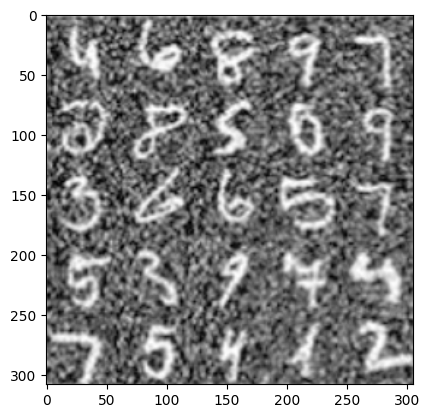

In [20]:
plt.imshow(first_image , cmap = 'gray')

### IMAGE 1

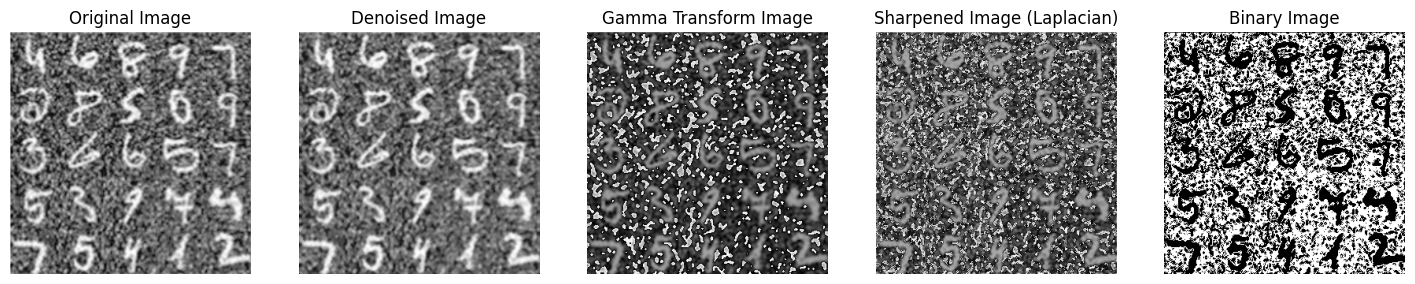

In [21]:
first_image_shape = first_image.shape

denoised_image = np.copy(first_image)
kernal_size = 3
padding = (kernal_size - 1 ) // 2

padded_image = np.pad(first_image , padding , mode='constant')

# Apply Median Filter

for i in range(first_image_shape[0]):
    for j in range(first_image_shape[1]):
        extracted_window = padded_image[i:i+kernal_size , j:j+kernal_size]
        denoised_image[i , j] = np.median(np.sort(extracted_window))
        
        
# Apply gamma transform

def gamma_transform(image, gamma=0.4):
    c = 255 / np.log(1+np.max(image))
    gamma_image = c * (image.astype(np.float32) ** gamma)  
    return np.uint8(gamma_image)  
    
gamma_corrected = gamma_transform(denoised_image, gamma=0.4)


# Apply laplacian filter

def laplacian_filter(image):
    
    # Define laplacian kernal
    kernal = np.array([
        [0 , 1 , 0],
        [1 , -4 , 1],
        [0 , 1 , 0]
    ]) 
    
    padded_image = np.pad(image , 1)
    
    temp_result = np.copy(image)
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            extracted_window = padded_image[i:i+3 , j:j+3]
            sum_at_position = np.sum(extracted_window * kernal)
            # if sum_at_position < 0:
            #     sum_at_position = 0
            # if sum_at_position > 255:
            #     sum_at_position = 255
            temp_result[i , j] = sum_at_position
        
    # return np.clip(temp_result , 0 , 255).astype(np.int8)
    return temp_result

laplacian_edges = laplacian_filter(gamma_corrected)

sub_result = gamma_corrected - laplacian_edges
sharpened_image = np.clip(sub_result, 0, 255).astype(np.uint8)


def global_threshold(image , threshold = 80):
    binary_image = np.zeros_like(image , dtype=np.uint8)
    
    for i in range(first_image.shape[0]):
        for j in range(first_image.shape[1]):
            if image[i , j] < threshold:
                binary_image[i , j] = 255
            else:
                binary_image[i , j] = 0 
    return binary_image

binary_image = global_threshold(sharpened_image)


plt.figure(figsize=(18, 5))

plt.subplot(1, 5, 1)
plt.imshow(first_image, cmap='gray')
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 5, 2)
plt.imshow(denoised_image, cmap='gray')
plt.title("Denoised Image")
plt.axis("off")

plt.subplot(1, 5, 3)
plt.imshow(gamma_corrected, cmap='gray')
plt.title("Gamma Transform Image")
plt.axis("off")

plt.subplot(1, 5, 4)
plt.imshow(sharpened_image, cmap='gray')
plt.title("Sharpened Image (Laplacian)")
plt.axis("off")

plt.subplot(1, 5, 5)
plt.imshow(binary_image, cmap='gray')
plt.title("Binary Image")
plt.axis("off")

plt.show()


### IMAGE 2

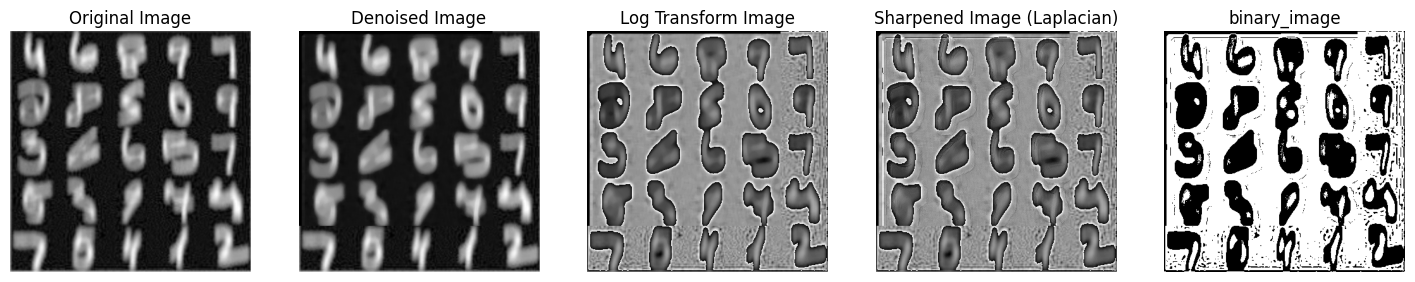

In [22]:
denoised_image = np.copy(second_image)
kernal_size = 8
padding = kernal_size - 1 // 2
padded_image = np.pad(second_image , padding , mode='constant')

# Apply Median Filter

for i in range(first_image_shape[0]):
    for j in range(first_image_shape[1]):
        extracted_window = padded_image[i:i+kernal_size , j:j+kernal_size]
        denoised_image[i , j] = np.median(np.sort(extracted_window))
        
        
# Apply gamma transform

def gamma_transform(image, gamma=0.4):
    c = 255 / np.log(1+np.max(image))
    gamma_image = c * (image.astype(np.float32) ** gamma)  
    return np.uint8(gamma_image)  

gamma_corrected = gamma_transform(denoised_image, gamma=0.4)


# Apply laplacian filter
def laplacian_filter(image):
    
    # Define laplacian kernal
    kernal = np.array([
        [0 , 1 , 0],
        [1 , -4 , 1],
        [0 , 1 , 0]
    ]) 
    padded_image = np.pad(image , padding , mode='constant')
    
    temp_result = np.zeros_like(image)
    
    for i in range(first_image.shape[0]):
        for j in range(first_image.shape[1]):
            extracted_window = padded_image[i:i+3 , j:j+3]
            sum_at_position = np.sum(extracted_window * kernal)
            # if sum_at_position < 0:
            #     sum_at_position = 0
            # if sum_at_position > 255:
            #     sum_at_position = 255
            temp_result[i , j] = sum_at_position
        
    return np.clip(temp_result , 0 , 255).astype(np.int8)

laplacian_edges = laplacian_filter(gamma_corrected)

sharpened_image = np.clip(gamma_corrected - laplacian_edges, 0, 255).astype(np.uint8)


def global_threshold(image , threshold = 120):
    binary_image = np.zeros_like(image , dtype=np.uint8)
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i , j] > threshold:
                binary_image[i , j] = 255
            else:
                binary_image[i , j] = 0             
    return binary_image
                
binary_image = global_threshold(sharpened_image)


plt.figure(figsize=(18, 5))
plt.subplot(1, 5, 1)
plt.imshow(second_image, cmap='gray')
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 5, 2)
plt.imshow(denoised_image, cmap='gray')
plt.title("Denoised Image")
plt.axis("off")

plt.subplot(1, 5, 3)
plt.imshow(gamma_corrected, cmap='gray')
plt.title("Log Transform Image")
plt.axis("off")

plt.subplot(1, 5, 4)
plt.imshow(sharpened_image, cmap='gray')
plt.title("Sharpened Image (Laplacian)")
plt.axis("off")

plt.subplot(1, 5, 5)
plt.imshow(binary_image, cmap='gray')
plt.title('binary_image')
plt.axis("off")


plt.show()

### QUESTION 3

In [29]:
image = cv2.imread('Q3_image.png' , cv2.IMREAD_GRAYSCALE)


In [ ]:
# Set threshold for detecting dark watermark
threshold = 180
mask = image < threshold  # Apply Boolean mask

def remove_watermark(image, mask):
    temp_image = np.copy(image)
    height, width = image.shape
    sixteen_neighbors = [
    
    (-1, -1), (-1, 0), (-1, 1), # Standard 8 neighbors
    (0, -1),          (0, 1),
    (1, -1),  (1, 0), (1, 1),
    
    (-2, -1), (-2, 1),
    (-1, -2), (-1, 2),
    (1, -2),  (1, 2),
    (2, -1),  (2, 1)
]   
    
    for i in range(height):
        for j in range(width):
            if mask[i, j]:
                neighbors = []
                for k, l in sixteen_neighbors:
                    new_i, new_j = i + k , j + l 
                    neighbors.append(image[new_i, new_j])

                if neighbors:
                    neighbors = np.array(neighbors)  
                    neighbors = neighbors[neighbors > 100]
                    temp_image[i, j] = np.mean(neighbors)
                # temp_image[i , j] = image[0 , 0]  
                

    return temp_image


def applysmoothening(image):
    denoised_image = np.copy(image)
    kernal_size = 3
    padding = (kernal_size - 1 ) // 2

    padded_image = np.pad(image , padding , mode='constant')
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            extracted_window = padded_image[i:i+kernal_size , j:j+kernal_size]
            denoised_image[i , j] = np.median(np.sort(extracted_window))
    return denoised_image

# Remove Watermark
restored_image = remove_watermark(image, mask)

#Apply smoothening by median blur
smoothened_image = applysmoothening(restored_image)

# Plot all images
plt.figure(figsize=(15, 8))
plt.subplot(1, 4, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(mask, cmap='gray') 
plt.title("Detected Watermark")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(restored_image, cmap='gray')
plt.title("Restored Image")
plt.axis("off")

plt.subplot(1, 4, 4 )
plt.imshow(smoothened_image, cmap='gray')
plt.title("Final Smoothened Image")
plt.axis("off")


cv2.imwrite('Q3_outputImage.png' , smoothened_image)

plt.show()

C:\Users\muham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\muham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\muham\AppData\Local\Temp\ipykernel_7816\3583314471.py:31: RuntimeWarning: invalid value encountered in cast
  temp_image[i, j] = np.mean(neighbors)


KeyboardInterrupt: 